In [1]:
import sys
import os
# ROOT_DIR=os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
ROOT_DIR=r'C:\Users\logan\Desktop\MEng\Mask_RCNN'
sys.path.append(ROOT_DIR)


import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math

# load the class label names from disk, one label per line
# CLASS_NAMES = open("coco_labels.txt").read().strip().split("\n")

# ROOT_DIR=os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
CLASS_NAMES = ['BG', 'Ice','Ship']
TestDir="\\IceData\\test_imgs\\"
# TestDir="\\IceData\\stage1_save\\"
TrainedWeights=ROOT_DIR+"\\mask_rcnn_iceshiptf1config_0050.h5"

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "Ice_ship_interference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
model.load_weights(filepath=TrainedWeights, 
                   by_name=True)

# load the input image, convert it from BGR to RGB channel
Test_Dir=os.listdir(ROOT_DIR+ TestDir) #lists the kangaroo test image dir
randomImg=Test_Dir[random.randint(0,len(Test_Dir)-1)]
image = cv2.imread(ROOT_DIR+TestDir+randomImg) #picks a random image in the kangaroo test image dir.
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
# print('Chosen random file to display with mask predictions: ',randomImg)

c:\Users\logan\Desktop\MEng\Mask_RCNN\.py379_venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\logan\Desktop\MEng\Mask_RCNN\.py379_venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\logan\Desktop\MEng\Mask_RCNN\.py379_venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\logan\Desktop\MEng\Mas








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


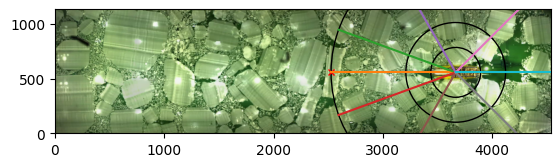

Crossing guard
lenc 58696
random 35979


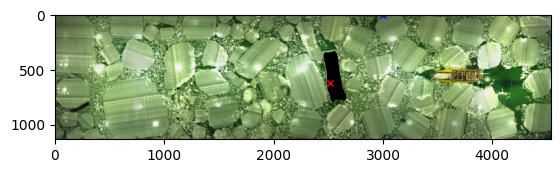

(array([327, 327, 328, ..., 793, 793, 793], dtype=int64), array([2545, 2546, 2541, ..., 2536, 2537, 2538], dtype=int64))


In [2]:

def visualize (image,r):
    mrcnn.visualize.display_instances(image=image, 
                                    boxes=r['rois'], 
                                    masks=r['masks'], 
                                    class_ids=r['class_ids'], 
                                    class_names=CLASS_NAMES, 
                                    scores=r['scores'])

def getshipdrxn(mask,centroid,radius):
    ## TODO add way to consider alternat headings here
    # this needs to return the DELTA ONLY
    p0=centroid
    ptend=[centroid[0]-radius,centroid[1]] #this returns a point, the distance of 1 radius away
    p1=[-radius,0] #this needs to be updated to account for variations in heading of the masked ship
    return [p0,p1,ptend]

def getcentroid(m): 
    #m is one mask
    ##get xy coordinates of each item, then avg them
    horiz = np.where(np.any(m, axis=0))[0]
    verti = np.where(np.any(m, axis=1))[0]
    
    hmax,hmin = horiz[[0, -1]]
    
    ShipL=abs(hmax-hmin) #shiplength in px

    hori_mean=np.mean(horiz)
    verti_mean=np.mean(verti)

    return [hori_mean,verti_mean,ShipL]

def addlines(plt,radius,angleIncrement,center,equalangles=True):
    ##if equalangles is true then angle increment should be an integer, otherwise
    angles=[]
    if equalangles: 
        if isinstance(angleIncrement, float):
            print("angle increment should be integer")
            exit()
        for n in range(1,round(360/angleIncrement)):
            angles.append(n*math.radians(angleIncrement))
    
    if not equalangles:
        for deg in angleIncrement: 
            angles.append(math.radians(deg))
            angles.append(math.radians(-deg))
    
    for angle in angles: 
        plt.plot([center[0],center[0]-radius*math.cos(angle)],[center[1],center[1]+radius*math.sin(angle)])
    
    #  OLD BELOW 
    # Nlines=round(360/angleIncrement)
    # rad_increment=math.radians(angleIncrement)
    
    # for i in range(1,Nlines):
    #     plt.plot([center[0],center[0]-radius*math.cos(rad_increment*i)],[center[1],center[1]+radius*math.sin(rad_increment*i)])
    

#### this is a staging ground to develop this function and move it back to the Extract_data.py file.
## the point of this function is to record the concentration of ice in certain areas relative to the ship;;; NOTE: does rely on the ship being detected.....and being detected correctly.
masks=r['masks']
boxes=r['rois']
classes = r['class_ids']
class_ids=classes.tolist()
scores=r['scores'] 

# Find ship mask and make sure there is only one ship "found"
i=CLASS_NAMES.index('Ship')
shipIndex=np.where(classes==i)[0]

if shipIndex.shape[0] != 1: 
    ## TODO: Implement some kind of way to pick the highest probability ship mask as "the" ship
    print("\n\n we have identified more than one ship \n\n")
    exit() #be dramatic incase i forget to do this
    None

# Find direction of ship -- find where the mask comes to a point.
t=classes[shipIndex[0]]
shipRoi=boxes[50]
shipclassid=classes[50]
sscore=scores[50]
shipmask = masks[:, :, shipIndex[0]][:, :, np.newaxis]

out={"rois":np.array([shipRoi]),
    "class_ids":np.array([class_ids[50]]),
    "scores":np.array([sscore]),
    "masks":shipmask}

## area of this mask
shiparea=np.reshape(shipmask, (-1, shipmask.shape[-1])).astype(np.float32).sum()
    
# visualize(image,out) #this is here to viz the boat mask only
img=np.where(shipmask,0,image).astype(np.uint8) 
        
x,y,ShipLength=getcentroid(shipmask)
centroid=np.array([x,y])

#this visualizes the centroid to prove that its in the right spot.
# a=plt.imshow(img)
# plt.plot(x,y,'rx',markersize=5)
# plt.show()

##get the direction
p0,p1,ptend=getshipdrxn(shipmask,centroid,radius=2.5*ShipLength)

#show the direction-------------------------------------------------------------------------------------------------------

fig=plt.figure()
ax0=fig.add_subplot(1,1,1) #same as prev
ax0.imshow(image)

plt.plot(p0[0],p0[1],'rx',markersize=5)
plt.plot(ptend[0],ptend[1],'rx',markersize=5)
# plt.arrow(p0[0],p0[1],-2.5*ShipLength,0,color='black',length_includes_head=True,head_width=100, head_length=100)
# plt.arrow(p0[0],p0[1],1*ShipLength,0,color='black',)

# plt.gca().add_patch(plt.Circle((p0[0],p0[1]), 1*ShipLength, color='r',fill=False))
# plt.gca().add_patch(plt.Circle((p0[0],p0[1]), 2.5*ShipLength, color='r', fill=False))

radii=[0.5,1,2.5]
for radius in radii:
    plt.gca().add_patch(plt.Circle((p0[0],p0[1]), radius*ShipLength, color='black', fill=False))

addlines(plt,radius=2.5*ShipLength,equalangles=False,angleIncrement=[0,20,60,135,180],center=p0)
plt.xlim(0, image.shape[1])
plt.ylim(0, image.shape[0])
plt.show()

print("Crossing guard")
## TODO implement these remaining steps: 
# 1) make a method to determine ship direction #ignoring this
# 2) add cylindrical polar coordinate system to the model, aligned in the direction the ship is pointing
# 3) divide cyl coordinates into regions defined by azimuth angle +- from true heading, and radius from centroid of ship mask
# 4) Get stats of ice present in the above defined regions: Specifically surface area of ice (floes), SA brash ice, area of region (total),
# assuming gaussian distribution of ice get std dev, 

## Get total mask area in pixels
# area=np.reshape(r['masks'], (-1, r['masks'].shape[-1])).astype(np.float32).sum()


current_mask=masks[:, :, 1][:, :, np.newaxis]

chk=np.where(current_mask,0,image).astype(np.uint8) 


plt.imshow(chk)

c=np.where(current_mask)[0:2] ## C[0] is y axis and C[1] is x axis!!!!!!!!!!!!!! backwards!!!
print('lenc',len(c[0]))

n=random.randint(0,len(c[0]))
print('random',n)
plt.plot(c[1][n],c[0][n],'rx',markersize=5)
plt.plot(3000,0,'bx',markersize=5)
plt.show()
print(c)




In [44]:
import pandas as pd
adf=pd.DataFrame({
    "id": [7058, 7059, 7072, 7054],
    "name": ['sravan', 'jyothika', 'harsha', 'ramya'],
    "subjects": ['java', 'python', 'html/php', 'php/js']
}
)

filename=r'C:\\Users\\logan\\Desktop\\MEng\\Mask_RCNN\\.rawForcedata\\12p5m_9ths_0p5kts_0p6m_0deg_001_Processed_MS_50Hz.csv'

df=pd.read_csv(filename)
# print(df)

OriginalData=df[:1].values.tolist()[0]
# print(l)

# l_1=l[0:7]
# print(l_1)
# l_2=l[8:11]
# newl=l_1+l_2

# print(newl)
# print(len(newl))

floesize=float(OriginalData[6].replace('p','.'))
print(type(floesize))

ds=OriginalData[8]
driftspeed=float(ds.replace('kts','').replace('p','.'))
print(type(driftspeed))

ithick=OriginalData[9]
iceThickness=float(ithick.replace('m','').replace('p',''))
print(type(iceThickness))

print(OriginalData)
m=OriginalData[0:6]+[floesize]+[driftspeed]+[iceThickness]+[OriginalData[10]]
print(m)




<class 'float'>
<class 'float'>
<class 'float'>
[0, 0.0004, -9.817671429, -0.727092857, 9.844985714285714, 1.6574785714285711, '12p5', '9ths', '0p5kts', '0p6m', 0, 1]
[0, 0.0004, -9.817671429, -0.727092857, 9.844985714285714, 1.6574785714285711, 12.5, 0.5, 6.0, 0]


In [3]:
angle=math.degrees(math.atan2(1,-1))

print(angle)

135.0


In [42]:
def BinarySearch(searchlist,R): 
    import bisect
    indi=bisect.bisect_left(searchlist,R)
    ii=bisect.bisect_right(searchlist,R)
    listlength=len(searchlist)

    if indi == ii: 
        if ii >= listlength and indi >= listlength: # this deals with the case when the number is greater than the max number on the list
            # print("none")
            bounds=0
        else: #this deals with all 'regular' cases; where the input number is between two items on the list
            # print("regular between:",searchlist[indi-1],searchlist[ii])
            bounds=[searchlist[indi-1],searchlist[ii]]
    if indi != ii:
        if ii >= listlength: # this deals with the case where we are on the upper line - goes into the smaller category
            # print("onthe topline between:",searchlist[indi-1],searchlist[ii-1])
            bounds=[searchlist[indi-1],searchlist[ii-1]]
        else: #this deals with cases where R lies on the dividing line -- goes into the bigger category
            # print("ontheline between:",searchlist[indi],searchlist[ii])
            bounds=[searchlist[indi],searchlist[ii]] 
    
    #we want to read bounds as 0:20, and 0:-20 NOT -20:0 (ascending order)
    if bounds[0] >=0 and bounds[1] >=0: #no negatives? pass, it should be in ascending order
        return bounds
    else: # if theres negatrives, make the order descending
        return [bounds[1],bounds[0]]
        
          
    

In [48]:
#####this is learning howto drop +1 into correct category.
ShipLength=100
RegionDefinition={"Radii":[0.5*ShipLength,1*ShipLength,2.5*ShipLength],"AngleIncrements":[20,60,135,180]} #do NOT explicitly say 0 degrees.    
# Initialize dictionary of the regions; these will be filled in later with sub-dictionaries that have the "index-class" of the detection we found
regionStats={}
prevRadi=0
prevAngl=0
regionStats["Centroids"]=[] #empty list, eventually will be a list of lists, where each sub list is the x,y coords of a centroid. Purely for vis purposes later
for Radi in RegionDefinition["Radii"]:
    for angl in RegionDefinition["AngleIncrements"]: 
        regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{angl}"]={}
        if prevAngl != 0:
            regionStats[f"Region_{prevRadi}:{Radi}_{-prevAngl}:{-angl}"]={}
        else: 
            regionStats[f"Region_{prevRadi}:{Radi}_{prevAngl}:{-angl}"]={}
        prevAngl=angl
    prevRadi=Radi
    prevAngl=0

##testing purposes only define these vals
N0=1    
centroid=[1154,500]
R=40
theta=-1

##implement binary serching here, cuz if we bump up the number of regions it blows up and we can get caught searching through each range to find where we belong
rlist=RegionDefinition["Radii"].copy()
rlist.append(0)
rbounds=BinarySearch(sorted(rlist),R)
a=[[value, -value] for value in RegionDefinition["AngleIncrements"]]
a1=[item for sublist in a for item in sublist] #flatten list of lists
a1.append(0)
angleList=sorted(a1)
abounds=BinarySearch(angleList,theta)

regionStats['Centroids'].append(centroid)
if rbounds == 0 or abounds == 0: 
    print("out of range of consideration")
elif rbounds != 0 and abounds != 0: 
    print(R,"dist between",rbounds[0],"&",rbounds[1])
    print(theta,"deg between",abounds[0],"&",abounds[1]) 
    
    regionStats[f"Region_{rbounds[0]}:{rbounds[1]}_{abounds[0]}:{abounds[1]}"][f'Index:{N0}']=400
    if not f'Index:{N0}' in regionStats[f"Region_{rbounds[0]}:{rbounds[1]}_{abounds[0]}:{abounds[1]}"]: #initialize: set this index =1
        regionStats[f"Region_{rbounds[0]}:{rbounds[1]}_{abounds[0]}:{abounds[1]}"][f'Index:{N0}']=1
    else:
        regionStats[f"Region_{rbounds[0]}:{rbounds[1]}_{abounds[0]}:{abounds[1]}"][f'Index:{N0}']+=1

print(RegionDefinition)
print(regionStats)

40 dist between 0 & 50.0
-1 deg between 0 & -20
{'Radii': [50.0, 100, 250.0], 'AngleIncrements': [20, 60, 135, 180]}
{'Centroids': [[1154, 500]], 'Region_0:50.0_0:20': {}, 'Region_0:50.0_0:-20': {'Index:1': 401}, 'Region_0:50.0_20:60': {}, 'Region_0:50.0_-20:-60': {}, 'Region_0:50.0_60:135': {}, 'Region_0:50.0_-60:-135': {}, 'Region_0:50.0_135:180': {}, 'Region_0:50.0_-135:-180': {}, 'Region_50.0:100_0:20': {}, 'Region_50.0:100_0:-20': {}, 'Region_50.0:100_20:60': {}, 'Region_50.0:100_-20:-60': {}, 'Region_50.0:100_60:135': {}, 'Region_50.0:100_-60:-135': {}, 'Region_50.0:100_135:180': {}, 'Region_50.0:100_-135:-180': {}, 'Region_100:250.0_0:20': {}, 'Region_100:250.0_0:-20': {}, 'Region_100:250.0_20:60': {}, 'Region_100:250.0_-20:-60': {}, 'Region_100:250.0_60:135': {}, 'Region_100:250.0_-60:-135': {}, 'Region_100:250.0_135:180': {}, 'Region_100:250.0_-135:-180': {}}
